In [17]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
sns.set()

def corrPlot(df):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    corr = df.corr()
    sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

def getReport(predictions, flag):
    if flag == 'test':
        theDf = target_test
    elif flag == 'val':
        theDf = target_val
    print("Balanced_Accuracy:", balanced_accuracy_score(theDf, predictions))
    print(classification_report(theDf, predictions))
    
def plotROC(model, flag):
    if flag == 'test':
        features = features_test
        target = target_test
    elif flag == 'val':
        features = features_val
        target = target_val
    probabilities = model.predict_proba(features)
    preds = probabilities[:,1]
    fpr, tpr, threshold = roc_curve(target, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.show()
    
    return plt

### Reading in Data

In [19]:
df = pd.read_csv('../ready4Learning2.csv', index_col = 0)
df.drop(df.tail(1).index,inplace=True)
df['Age@Scan'] = df['Age@Scan'].astype('float64')

print(df.ConsensusDiagnosis.value_counts())

print("\nDataType")
print(df['Age@Scan'].dtypes)

0    482
1    261
Name: ConsensusDiagnosis, dtype: int64

DataType
float64


In [20]:
target = df.ConsensusDiagnosis
features = df.drop(['ConsensusDiagnosis', 'UNK', 'QMC', 'OTH', 'ScanDate'], axis = 1)

### Standardizing for PCA

In [5]:
from sklearn.preprocessing import StandardScaler
features = StandardScaler().fit_transform(features)

from sklearn.preprocessing import Normalizer
features = Normalizer().fit_transform(features)



from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=0, )
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size = 0.3, random_state = 0)

### PCA

Running experiments w/ 112 state vs 2 state PCA

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)

pca.fit_transform(features_train)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.56215398 0.12165172]
0.6838056965930884


### Finding Eigenvalues

Text(0, 0.5, '0, 1')

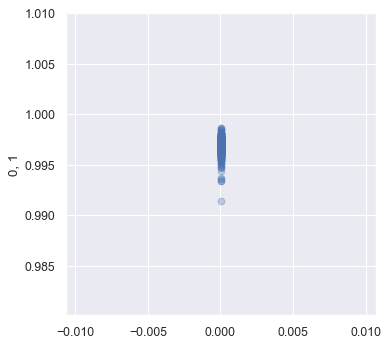

In [7]:
import seaborn as sns
sns.set()

figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(features_train[:, 0], features_train[:, 1], alpha = 0.3)
plt.ylabel('0, 1')

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


logit = LogisticRegression(solver='liblinear', max_iter=500)

best_logit = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0.0001, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

penalties = ['l1', 'l2']
tols = [1e-2, 1e-3, 1e-4]
costs = [0.001, 0.01, 0.1, 1, 5, 10]
intercepts = [0.0001, 0.001, 0.1, 1]
fit_intercepts = [True, False]
classWeights = [None, 'balanced']

params_logit = {'C': costs, 'penalty': penalties, 'tol': tols, 
                'fit_intercept': fit_intercepts, 'class_weight': classWeights, 'intercept_scaling': intercepts}

gs_logit = GridSearchCV(logit, params_logit, cv=10)

best_logit.fit(features_train, target_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0.0001, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Balanced_Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       137
           1       0.00      0.00      0.00        64

   micro avg       0.68      0.68      0.68       201
   macro avg       0.34      0.50      0.41       201
weighted avg       0.46      0.68      0.55       201



/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<module 'matplotlib.pyplot' from '/Users/hhuang85/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

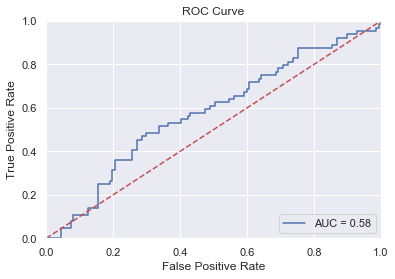

In [9]:
predictions = best_logit.predict(features_val)
getReport(predictions, 'val')
plotROC(best_logit, 'val')

Balanced_Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.63      1.00      0.77        47
           1       0.00      0.00      0.00        28

   micro avg       0.63      0.63      0.63        75
   macro avg       0.31      0.50      0.39        75
weighted avg       0.39      0.63      0.48        75



/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<module 'matplotlib.pyplot' from '/Users/hhuang85/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

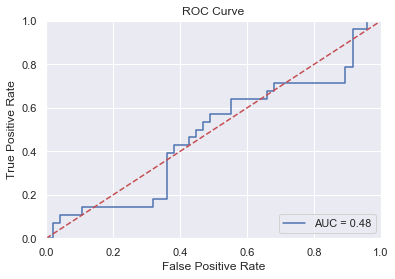

In [10]:
predictions = best_logit.predict(features_test)
getReport(predictions, 'test')
plotROC(best_logit, 'test')

### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)

num_trees = [10, 15, 20, 25, 30, 40, 50]
criterion = ['gini']
max_depth = [10, 20, 30]
min_samples_leaf = [1,2,3,4]
min_samples_split = [1,2,3,4]

params_rf = {'n_estimators': num_trees, 'criterion': criterion, 'max_depth': max_depth}
gs_rf = GridSearchCV(rf, params_rf, cv=10)

gs_rf.fit(features_train, target_train)
gs_rf.best_estimator_

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Balanced_Accuracy: 0.6744411496350364
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       137
           1       0.73      0.42      0.53        64

   micro avg       0.77      0.77      0.77       201
   macro avg       0.75      0.67      0.69       201
weighted avg       0.76      0.77      0.75       201



<module 'matplotlib.pyplot' from '/Users/hhuang85/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

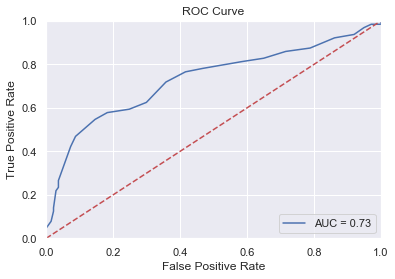

In [15]:
predictions = gs_rf.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_rf, 'val')

Balanced_Accuracy: 0.6751519756838906
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        47
           1       0.85      0.39      0.54        28

   micro avg       0.75      0.75      0.75        75
   macro avg       0.79      0.68      0.68        75
weighted avg       0.77      0.75      0.72        75



<module 'matplotlib.pyplot' from '/Users/hhuang85/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

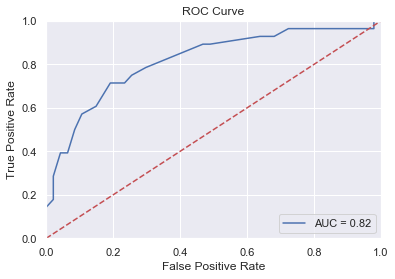

In [16]:
predictions = gs_rf.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_rf, 'test')